In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

In [ ]:
def intercatchments_from_catchments(gdf, id_col):
    """(Sub-)Catchment boundaries derived for outflow points will often overlap.
    In many cases, we want non-overlapping "intercatchments" rather than true
    catchments.

    This function generates intercatchments from true sub-catchments.

    NOTE: This function is rough and needs proper testing.

    Args
        gdf:    Geodataframe. Polygons of "true" overlapping (sub-)catchments
        id_col: Str. Name of column in 'gdf' containing a unique ID for each
                sub-catchment.

    Returns
        Geodataframe of non-overlapping intercatchments.
    """
    assert all(
        gdf.geometry.geom_type.isin(["Polygon", "MultiPolygon"])
    ), "'gdf' must only contain Polygons or MultiPolygons."
    assert gdf.crs is not None, "'gdf' does not have a valid CRS."
    assert gdf[id_col].is_unique, f"Column '{id_col}' is not unique."

    gdf = gdf.copy()

    # Sort by area from largest to smallest
    gdf["original_order"] = np.arange(len(gdf))
    gdf["area_temp_km2"] = gdf.to_crs({"proj": "cea"}).geometry.area / 1e6
    gdf.sort_values("area_temp_km2", ascending=False, inplace=True)

    # Create a new GeoDataFrame to store the result
    inter_gdf = gpd.GeoDataFrame(columns=gdf.columns)

    # Clip each polygon with all those that are smaller
    for i, (index, row) in enumerate(gdf.iterrows()):
        cat_poly = gdf.iloc[i].geometry
        small_polys = gdf.iloc[i + 1 :].geometry

        # Subtract the smaller overlapping areas from the current polygon
        for small_poly in small_polys:
            cat_poly = cat_poly.difference(small_poly)

        # Assign the resulting polygon to the row's geometry
        row.geometry = cat_poly
        inter_gdf = pd.concat([inter_gdf, gpd.GeoDataFrame(row).T], ignore_index=True)

    # Tidy
    inter_gdf = inter_gdf.sort_values(by="original_order").reset_index(drop=True)
    inter_gdf = inter_gdf.drop(columns=["area_temp_km2", "original_order"])

    return inter_gdf

In [2]:
# Read example .shp
shp_path = r"/home/jovyan/shared/common/oslofjord_modelling/catchment_spatial_data/sandvikselva_delineated_scs.shp"
gdf = gpd.read_file(shp_path)

# Not sure why, but example .shp from Leah is missing CRS info. Set manually
gdf.crs = "epsg:25833"
gdf.head()

,SC_id,name,catch_boun,outlet_utm,outlet_u_1,inputs_fro,WQ_point,Q_id,area,geometry
0,Ø1,Sæternbekken,delineate,252405.0874,6653449.342,None,None,08.06.2000,6089500.0,"POLYGON ((250830.000 6657220.000, 250860.000 6..."
1,Ø2,Blomsterkroken,delineate,251834.6173,6649495.120,008.A1Z,008-60882,08.08.2000,22495400.0,"POLYGON ((251500.000 6658670.000, 251520.000 6..."
2,I2,Isielva_bjørum,delineate,244671.0000,6653233.000,None,008-91965,None,48289300.0,"POLYGON ((241240.000 6665420.000, 241240.000 6..."
3,S1,Sandvikselva_bjørnegårdssvingen,delineate,248777.3740,6648072.856,"008.AAZ, 008.AA0, 008.A2, 008.A12",008-60878,08.02.2000,189898000.0,"POLYGON ((244700.000 6673250.000, 244700.000 6..."


<Axes: >

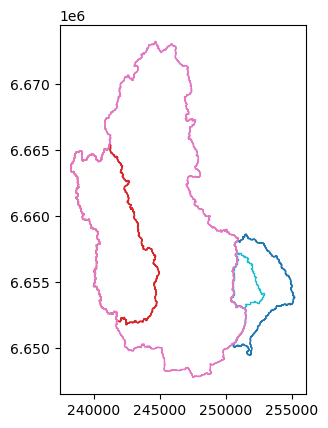

In [3]:
# Plot ovelapping true sub-catchments
gdf.plot(column="name", facecolor="none")

In [5]:
# Get intercatchments
inter_gdf = intercatchments_from_catchments(gdf, "SC_id")
inter_gdf

,SC_id,name,catch_boun,outlet_utm,outlet_u_1,inputs_fro,WQ_point,Q_id,area,geometry
0,Ø1,Sæternbekken,delineate,252405.0874,6653449.342,None,None,08.06.2000,6089500.0,"POLYGON ((250830.000 6657220.000, 250860.000 6..."
1,Ø2,Blomsterkroken,delineate,251834.6173,6649495.12,008.A1Z,008-60882,08.08.2000,22495400.0,"POLYGON ((251520.000 6658670.000, 251520.000 6..."
2,I2,Isielva_bjørum,delineate,244671.0,6653233.0,None,008-91965,None,48289300.0,"POLYGON ((241260.000 6665410.000, 241260.000 6..."
3,S1,Sandvikselva_bjørnegårdssvingen,delineate,248777.374,6648072.856,"008.AAZ, 008.AA0, 008.A2, 008.A12",008-60878,08.02.2000,189898000.0,"POLYGON ((244720.000 6673150.000, 244730.000 6..."


<Axes: >

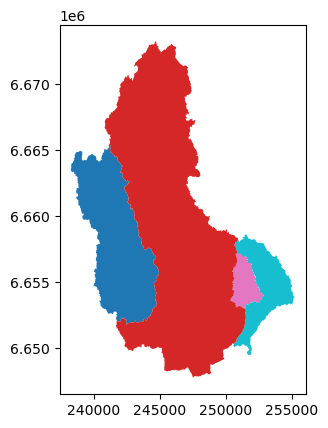

In [6]:
inter_gdf.plot(column="SC_id")